In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████████████████████████████████████████████████████████▉| 170180608/170498071 [00:48<00:00, 4012441.47it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [00:59, 4012441.47it/s]                                                                                    

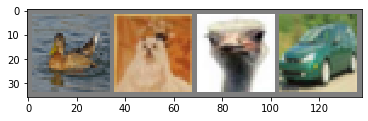

 bird   dog  bird   car


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)


conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = conv3x3(3,32)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = conv3x3(32,32)
        self.bn2 = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout2d(p=0.2)
        
        self.conv3 = conv3x3(32,64)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = conv3x3(64,64)
        self.bn4 = nn.BatchNorm2d(64)
        self.drop2 = nn.Dropout2d(p=0.3)
        
        self.conv5 = conv3x3(64,128)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = conv3x3(128,128)
        self.bn6 = nn.BatchNorm2d(128)
        self.drop3 = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(4*4*128, 128)
        self.drop4 = nn.Dropout(p=0.5)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.bn1(self.act(self.conv1(x)))
        x = self.bn2(self.act(self.conv2(x)))
        x = self.drop1(self.pool(x))
        
        x = self.bn3(self.act(self.conv3(x)))
        x = self.bn4(self.act(self.conv4(x)))
        x = self.drop2(self.pool(x))
        
        x = self.bn5(self.act(self.conv5(x)))
        x = self.bn6(self.act(self.conv6(x)))
        x = self.drop3(self.pool(x))
        
        x = x.view(-1, 4*4*128)
        x = self.bn7(self.act(self.fc1(x)))
        x = self.drop4(x)
        
        out = self.fc2(x)
        return out
        

In [6]:
net = Net()
#print(net)
for child in net.children():
    print(child)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2dAuto(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2dAuto(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Dropout2d(p=0.2, inplace=False)
Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Dropout2d(p=0.3, inplace=False)
Conv2dAuto(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2dAuto(128, 128, kernel_size=(3, 3), stride=(1

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [8]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')z



[1,  2000] loss: 2.245
[1,  4000] loss: 2.140
[1,  6000] loss: 2.141
[1,  8000] loss: 2.147
[1, 10000] loss: 2.116
[1, 12000] loss: 2.079
[2,  2000] loss: 2.059
[2,  4000] loss: 2.026
[2,  6000] loss: 2.002
[2,  8000] loss: 1.987
[2, 10000] loss: 1.950
[2, 12000] loss: 1.915
[3,  2000] loss: 1.908
[3,  4000] loss: 1.903
[3,  6000] loss: 1.852
[3,  8000] loss: 1.883
[3, 10000] loss: 1.853
[3, 12000] loss: 1.825
[4,  2000] loss: 1.841
[4,  4000] loss: 1.795
[4,  6000] loss: 1.813
[4,  8000] loss: 1.768
[4, 10000] loss: 1.752
[4, 12000] loss: 1.750
[5,  2000] loss: 1.708
[5,  4000] loss: 1.688
[5,  6000] loss: 1.682
[5,  8000] loss: 1.735
[5, 10000] loss: 1.718
[5, 12000] loss: 1.673
[6,  2000] loss: 1.690
[6,  4000] loss: 1.692
[6,  6000] loss: 1.672
[6,  8000] loss: 1.678
[6, 10000] loss: 1.658
[6, 12000] loss: 1.646
[7,  2000] loss: 1.589
[7,  4000] loss: 1.634
[7,  6000] loss: 1.603
[7,  8000] loss: 1.592
[7, 10000] loss: 1.596
[7, 12000] loss: 1.564
[8,  2000] loss: 1.612
[8,  4000] 

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [10]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2dAuto(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2dAuto(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout2d(p=0.3, inplace=False)
  (conv5): Conv2dAuto(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 90 %
Accuracy of  bird : 75 %
Accuracy of   cat : 61 %
Accuracy of  deer : 80 %
Accuracy of   dog : 82 %
Accuracy of  frog : 85 %
Accuracy of horse : 81 %
Accuracy of  ship : 94 %
Accuracy of truck : 90 %
